In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Dense, Dropout, BatchNormalization, Flatten, Add
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
# Load datasets
fake_df = pd.read_csv(r'C:\PC\MyCourses\ML_NLP_Filoger\Session13&14\news\Fake.csv')
true_df = pd.read_csv(r'C:\PC\MyCourses\ML_NLP_Filoger\Session13&14\news\True.csv')

# Add labels
fake_df['label'] = 0
true_df['label'] = 1

# Merge and shuffle
news_df = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)
news_df = news_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Combine title and text if both are present
if 'title' in news_df.columns and 'text' in news_df.columns:
    news_df['content'] = news_df['title'] + " " + news_df['text']
else:
    news_df['content'] = news_df['text']

# Drop null content rows
news_df = news_df.dropna(subset=['content'])

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(news_df['content'])

X_seq = tokenizer.texts_to_sequences(news_df['content'])
X_padded = pad_sequences(X_seq, maxlen=300, padding='post', truncating='post')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, news_df['label'], test_size=0.2, random_state=42)

In [3]:
def build_model():
    # Input Layer
    inputs = Input(shape=(300,))
    
    # Embedding Layer
    embedding = Embedding(input_dim=20000, output_dim=128, trainable=True)(inputs)
    
    # Flatten Layer
    flatten = Flatten()(embedding)
    
    # Dense Layer 1
    dense_1 = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(flatten)
    
    # Dense Layer 2
    dense_2 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(dense_1)
    
    # Dense Layer 3
    dense_3 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(dense_2)
    
    # Output Layer
    output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(dense_3)
    
    # Model
    model = Model(inputs, output)
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

# Build and summarize the model
model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 300, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 38400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      19,661,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,385,665 (85.39 MB)

 Trainable params: 22,385,665 (85.39 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=15, 
                    batch_size=64, 
                    verbose=2)#callbacks=[early_stopping, reduce_lr],

Epoch 1/15
562/562 - 103s - 184ms/step - accuracy: 0.9848 - loss: 0.5776 - val_accuracy: 0.9970 - val_loss: 0.1466
Epoch 2/15
562/562 - 93s - 166ms/step - accuracy: 0.9993 - loss: 0.1020 - val_accuracy: 0.9990 - val_loss: 0.0886
Epoch 3/15
562/562 - 90s - 160ms/step - accuracy: 0.9995 - loss: 0.0822 - val_accuracy: 0.9990 - val_loss: 0.0776
Epoch 4/15
562/562 - 82s - 145ms/step - accuracy: 0.9996 - loss: 0.0738 - val_accuracy: 0.9992 - val_loss: 0.0676
Epoch 5/15
562/562 - 89s - 158ms/step - accuracy: 0.9997 - loss: 0.0662 - val_accuracy: 0.9990 - val_loss: 0.0655
Epoch 6/15
562/562 - 85s - 150ms/step - accuracy: 0.9997 - loss: 0.0615 - val_accuracy: 0.9990 - val_loss: 0.0608
Epoch 7/15
562/562 - 92s - 163ms/step - accuracy: 0.9996 - loss: 0.0647 - val_accuracy: 0.9993 - val_loss: 0.0632
Epoch 8/15
562/562 - 77s - 137ms/step - accuracy: 0.9997 - loss: 0.0560 - val_accuracy: 0.9990 - val_loss: 0.0526
Epoch 9/15
562/562 - 77s - 136ms/step - accuracy: 0.9997 - loss: 0.0537 - val_accuracy:

In [5]:
# Evaluate performance
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict and print classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

Test Accuracy: 99.93%
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4710
           1       1.00      1.00      1.00      4270

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [8]:
yy = model.predict(X_test)
yy

281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


array([[0.00151689],
       [0.9960156 ],
       [0.99925417],
       ...,
       [0.0012269 ],
       [0.99897164],
       [0.9993631 ]], dtype=float32)

In [9]:
yy>0.5

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [ True],
       [ True]])

In [11]:
(yy>0.5).astype("int32")

array([[0],
       [1],
       [1],
       ...,
       [0],
       [1],
       [1]])

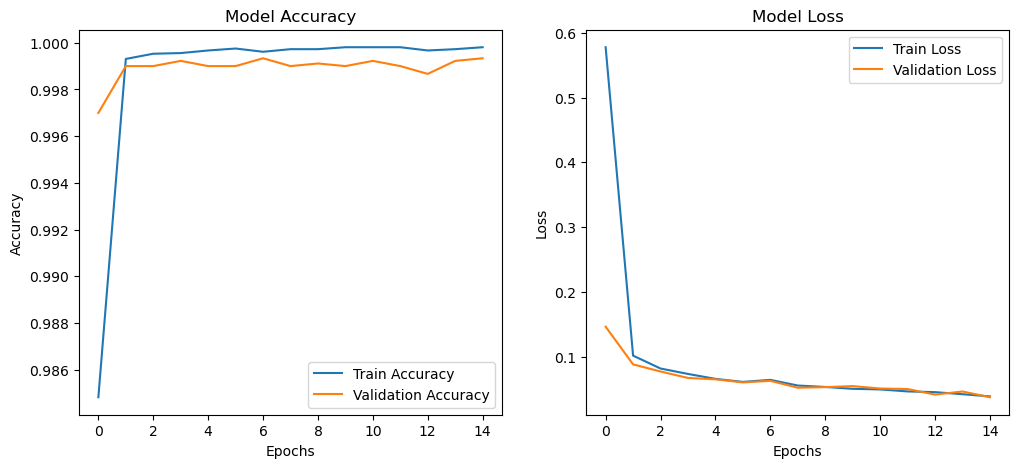

In [7]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()